In [87]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]


In [1]:
#---- to do list -----
# err_data_list 파일자동화
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

#pow 낮값만 추출 test
#pow = 0인 구간 : 0~4, 21-23시
powhr_start = 5
powhr_end   = 20

shift_days  = 3
hoursteps   = powhr_end-powhr_start+1 #(16)
timesteps   = shift_days*hoursteps #hours step

data_dim    = 7
out_dim     = 1
n_model    = 10

data_dir  = 'C:/Users/VISLAB_PHY/Desktop/Workspace/Data'

season_mod = 'all_1102_f7'
date_start = '10190901'
date_end   = '30191201'

err_date_list = ['20190912',
                    '20191122',
                    '20191130',
                    '20191217',
                    '20200501',
                    '20200502',
                    '20191028',
                    '20191107',
                    '20191108',
                    '20191109',
                    '20191110',
                    '20191111',
                    '20191112',
                    '20200214',
                    '20200307',
                    '20200308',
                    '20200309',
                    '20200310',
                    '20200328',
                    '20200329',
                    '20200625',
                    '20200809']

Using TensorFlow backend.


# Yeo-JohnsonTransformer

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 

transf_type = 'yeo-johnson'
#transf_type = 'box-cox'

def yeo_johnson_transform(dataset):
    
    column_trans = ColumnTransformer(
                    [('sunshine', PowerTransformer(method=transf_type, standardize=True), ['sunshine']),
                     ('humdt', PowerTransformer(method=transf_type, standardize=True), ['humdt']),
                     ('wnd_spd', PowerTransformer(method=transf_type, standardize=True), ['wnd_spd']),
                     ('visiblt', PowerTransformer(method=transf_type, standardize=True), ['visiblt']),
                     ('cloud2', PowerTransformer(method=transf_type, standardize=True), ['cloud2']),
                     ('cloud', PowerTransformer(method=transf_type, standardize=True), ['cloud']),
                     ('grd_temprt', PowerTransformer(method=transf_type, standardize=True), ['grd_temprt']),
                     ('wnd_dir', PowerTransformer(method=transf_type, standardize=True), ['wnd_dir']),
                     ('dewpnt', PowerTransformer(method=transf_type, standardize=True), ['dewpnt']),
                     ('steampressr', PowerTransformer(method=transf_type, standardize=True), ['steampressr']),
                     ('temprt', PowerTransformer(method=transf_type, standardize=True), ['temprt']),
                     ('mincloud', PowerTransformer(method=transf_type, standardize=True), ['mincloud']),
                     ('rain', PowerTransformer(method=transf_type, standardize=True), ['rain']),
                     ('pressr', PowerTransformer(method=transf_type, standardize=True), ['pressr']),
                     ('seapressr', PowerTransformer(method=transf_type, standardize=True), ['seapressr']),
                     ('snow', PowerTransformer(method=transf_type, standardize=True), ['snow'])
                    ])
    
    transformed_data = column_trans.fit_transform(dataset)
    transformed_df = pd.DataFrame(transformed_data, columns=dataset.columns)
    pd.concat([transformed_df], axis = 1)
                    
    return transformed_df

# Get weather, pow data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

#############################################
# 태양광 전력
#############################################
def get_pow():

    # pow 파일 load
    dir_path    = data_dir+"/pow_24/UR00000126_csv"
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    hrPow  = []    

    # pow측정값 에러가 큰 일자 제거
    for filename in file_list:
        if (filename[:-4] not in err_date_list):
            if ((filename[:-4]>=date_start) & (filename<date_end)):
                filedata = pd.read_csv(dir_path+'/'+filename).values[:,0]
                hrPow.append(filedata)
                
    #낮시간 추출 (5~20시)
    pow_dataset = pd.DataFrame(hrPow)
    pow_dataset =pow_dataset.iloc[:,powhr_start:powhr_end+1]
    #pow_dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow_hr.csv",mode='w',index=False)

    # 결측값 보간, reshape
    pow_dataset = pow_dataset.interpolate(method='linear')
    pow_dataset = pow_dataset.values.reshape(-1,1)
    pow_dataset = pd.DataFrame(pow_dataset)
    pow_dataset.columns = ['pow']
    pow_dataset.to_csv(data_dir+"/pow.csv",mode='w',index=False)

    
    # scale
    sc_pow = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = sc_pow.fit_transform(pow_dataset.values)
    df_pow = pd.DataFrame(scaled_pow, columns=pow_dataset.columns, index=list(pow_dataset.index.values))
    
    return df_pow, sc_pow

#############################################
# 종관기상관측
#############################################
def get_weather():
    # pow 파일 load
    file_list   = os.listdir(data_dir)
    print(len(file_list))
    for filename in os.listdir(data_dir):
        if fnmatch.fnmatch(filename, 'OBS_ASOS_TIM_*.csv'):
            print(filename)

            # load csv data
            dataset = read_csv(data_dir+'/'+filename, encoding='CP949')
            dataset.drop(['지점','지점명'], axis=1, inplace=True)
            dataset.drop(['기온 QC플래그','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['현지기압 QC플래그','해면기압 QC플래그','일조 QC플래그','지면온도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['5cm 지중온도(°C)','10cm 지중온도(°C)','20cm 지중온도(°C)','30cm 지중온도(°C)'], axis=1, inplace=True)
            dataset.drop(['3시간신적설(cm)','일사(MJ/m2)','운형(운형약어)','지면상태(지면상태코드)','현상번호(국내식)'], axis=1, inplace=True)

            # set column name
            dataset.columns = ['ymdhms', 'temprt', 'rain', 'wnd_spd', 'wnd_dir', 'humdt','steampressr',
                               'dewpnt', 'pressr','seapressr','sunshine','snow','cloud','cloud2','mincloud','visiblt','grd_temprt']

            # prioirty sort (피어슨상관계수)
            dataset = dataset[['ymdhms','sunshine','humdt','wnd_spd','visiblt','cloud2',
                               'cloud','grd_temprt','wnd_dir','dewpnt','steampressr','temprt',
                               'mincloud','rain','pressr','seapressr','snow']]


            # set NA data (관측값 0이 누적되어 결측된 경우. 0으로 세팅)
            dataset['rain'].fillna(0, inplace=True)     #강수량
            dataset['sunshine'].fillna(0, inplace=True) #일조
            dataset['snow'].fillna(0, inplace=True)     #적설량

            #일시 패턴 변환(2019-08-20 5:00 -> 2019082005)
            dataset['ymdhms'] = dataset['ymdhms'].str[0:4]+dataset['ymdhms'].str[5:7]+dataset['ymdhms'].str[8:10]+dataset['ymdhms'].str[11:13]
            # pow측정값 중 결측값 많은 일자 제거
            dataset = dataset[(dataset['ymdhms'].str[0:8]>=date_start) & (dataset['ymdhms'].str[0:8]<date_end)]
            for err_date in err_date_list:
                idx_err = dataset[dataset['ymdhms'].str.startswith(err_date)].index
                dataset = dataset.drop(idx_err)

            #낮시간 추출 (5~20시)
            dataset = dataset[(dataset['ymdhms'].str[-2:]>=str(powhr_start).rjust(2, '0')) &(dataset['ymdhms'].str[-2:]<=str(powhr_end))]
            dataset = dataset.interpolate(method='linear')# 결측값 보간
            
            # save file (test용)
            dataset.to_csv(data_dir+"/weather.csv",mode='w',index=False)

            # normalization
            dataset.drop(['ymdhms'], axis=1, inplace=True)
            dataset = dataset.astype('float32')
            dataset = dataset.interpolate(method='linear')
            
            #YEO-JOHNSON transform
            yeo_df = yeo_johnson_transform(dataset)
            
            #insert feature (test)
            yeo_df.insert(2, 'temp_press', yeo_df['temprt']-yeo_df['steampressr'], True)
            yeo_df.insert(2, 'sunshine_humdt', abs(yeo_df['sunshine'])-(yeo_df['humdt']*(2.1)), True)#0.35
            
            sc = MinMaxScaler(feature_range = (0, 1))#scale
            scaled_weather = sc.fit_transform(yeo_df.values)
            weather = pd.DataFrame(scaled_weather, columns=yeo_df.columns, index=list(yeo_df.index.values))
            print("before : ", weather.shape)
            weather = weather.iloc[:, 0:data_dim] #feature size 조절
            print("after : ", weather.shape)
            
    return weather


# Numpy data
weather, pow

In [4]:
#############################################
# numpy data 만들기
#############################################

df_pow, sc_pow   = get_pow()
df               = get_weather()

# pow + weather + powY
df.insert(0, 'pow', df_pow.values, True)
df = df.iloc[0:-timesteps, :]
df.insert(df.shape[1], 'pow_Y', df_pow.iloc[timesteps:, :].values, True)

df.to_csv(data_dir+"/total.csv",mode='w',index=False, encoding='CP949')

#----------------------------------------------
# time step만큼 window 움직여 dataset 생성
#----------------------------------------------
totalsize = df.shape[0]
dataX, dataY = [], []

for i in range(0, totalsize-timesteps-24+1, hoursteps):
    dataX.append(df.iloc[i:(i + timesteps),0:-1])
    dataY.append(df.iloc[i:(i + hoursteps),[0]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#----------------------------------------------
#  Split train/test 
#----------------------------------------------

train_size = int(len(dataX) * 0.7)
val_size   = int(len(dataX) * 0.2)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save("npset/"+season_mod+"_trainX",trainX)
np.save("npset/"+season_mod+"_trainY",trainY)
np.save("npset/"+season_mod+"_valX",valX)
np.save("npset/"+season_mod+"_valY",valY)
np.save("npset/"+season_mod+"_testX",testX)
np.save("npset/"+season_mod+"_testY",testY)


337
10
OBS_ASOS_TIM_20200929025447.csv


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


before :  (5344, 18)
after :  (5344, 7)
len(dataX) :  327 (48, 8)
len(dataY) :  327 (16, 1)
train X :  (228, 48, 8) 	Y :  (228, 16, 1)
val   X :  (65, 48, 8) 	Y :  (65, 16, 1)
test  X :  (34, 48, 8) 	Y :  (34, 16, 1)


# 모델 1

In [6]:
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(RepeatVector(hoursteps))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               271360    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 16, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 256)           525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 256)           65792     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 1)             257       
Total params: 862,721
Trainable params: 862,721
Non-trainable params: 0
_________________________________________________________________


# 모델 fit 반복돌리기
range 바꾸기

In [7]:
for i in range(n_model):#0,5):#

    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                  optimizer=RMSProp()
                  #optimizer=RMSProp(learning_rate=0.001)
                  #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                  #metrics=['acc'])
                 )

    hist = model.fit(trainX, 
                     trainY, 
                     epochs=300, 
                     batch_size=64,
                     validation_data=(valX, valY))


    results = model.evaluate(testX, testY)
    #model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    model.save('model/model_'+season_mod+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18

Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.1274 - val_loss: 0.0392
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.0360
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0378
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0298
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0589
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0462 - val_loss: 0.0360
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0302
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0475 - val_loss: 0.0436
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0334
Epoch 10/300
228/228 [========================

Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0122
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0127
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 87/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 88/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0094
Epoch 89/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 90/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0052

228/228 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 164/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 165/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 166/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0071
Epoch 167/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0071
Epoch 168/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 169/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0024 - v

228/228 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 240/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 241/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 242/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 243/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0075
Epoch 244/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 245/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 246/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 247/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 248/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0018 - v

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0072
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0071
Epoch 10/300
228/228 [========================

Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 87/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 88/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 89/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 90/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011

228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 164/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0063
Epoch 165/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 166/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 167/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 168/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 169/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - v

Epoch 239/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 240/300
228/228 [==============================] - 0s 1ms/step - loss: 9.8155e-04 - val_loss: 0.0034
Epoch 241/300
228/228 [==============================] - 0s 1ms/step - loss: 7.4026e-04 - val_loss: 0.0056
Epoch 242/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 243/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 244/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 245/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1899e-04 - val_loss: 0.0034
Epoch 246/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 247/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 248/300
228/228 [==============================] - 0s 1

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1841e-04 - val_loss: 0.0034
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 6.7049e-04 - val_loss: 0.0042
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 9.8128e-04 - val_loss: 0.0052
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 9.0186e-04 - val_loss: 0.0040
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 8.5338e-04 - val_loss: 0.0042
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10/300
228/228 [====

228/228 [==============================] - 0s 1ms/step - loss: 6.3925e-04 - val_loss: 0.0030
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 4.9258e-04 - val_loss: 0.0034
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 9.7661e-04 - val_loss: 0.0028
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9740e-04 - val_loss: 0.0033
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 6.3519e-04 - val_loss: 0.0029
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 9.8261e-04 - val_loss: 0.0026
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 7.3220e-04 - val_loss: 0.0028
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 9.4469e-04 - val_loss: 0.0036
Epoch 87/300
228/228 [==============================] - 0s 1ms/step - loss: 6.7706e-04 - val_loss: 0.0037
Epoch 88/300
228/228 [==============================] - 0s 

228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 7.5381e-04 - val_loss: 0.0038
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4845e-04 - val_loss: 0.0035
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 5.1195e-04 - val_loss: 0.0036
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 7.2957e-04 - val_loss: 0.0041
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 6.7402e-04 - val_loss: 0.0043
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 4.0372e-04 - val_loss: 0.0041
Epoch 164/300
228/228 [==============================] - 0s 1ms/step - loss: 4.7823e-04 - val_loss: 0.0051
Epoch 165/300
228/228 [==============================] - 0s

Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 8.0548e-04 - val_loss: 0.0043
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 5.6922e-04 - val_loss: 0.0040
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 3.7934e-04 - val_loss: 0.0054
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 8.0817e-04 - val_loss: 0.0049
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 8.0129e-04 - val_loss: 0.0041
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4637e-04 - val_loss: 0.0042
Epoch 239/300
228/228 [==============================] - 0s 1ms/step - loss: 4.6415e-04 - val_loss: 0.0044
Epoch 240/300
228/228 [==============================] - 0s 1ms/step - loss: 7.6626e-04 - val_loss: 0.0038
Epoch 241/300
228/228 [==============================] - 0s 1ms/step - loss: 4.4325e-04 - val_loss: 0.0035
Epoch 242/300
228/228 [==============

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 6.6110e-04 - val_loss: 0.0039
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9216e-04 - val_loss: 0.0041
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2134e-04 - val_loss: 0.0044
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 3.1227e-04 - val_loss: 0.0053
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 3.9780e-04 - val_loss: 0.0054
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 8.0812e-04 - val_loss: 0.0043
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 5.5978e-04 - val_loss: 0.0040
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 3.9745e-04 - val_loss: 0.0041
Epoch 10/300
2

228/228 [==============================] - 0s 1ms/step - loss: 4.1326e-04 - val_loss: 0.0042
Epoch 79/300
228/228 [==============================] - ETA: 0s - loss: 6.6522e-0 - 0s 1ms/step - loss: 6.1178e-04 - val_loss: 0.0045
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7497e-04 - val_loss: 0.0054
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 4.1660e-04 - val_loss: 0.0064
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 8.3353e-04 - val_loss: 0.0050
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 3.9610e-04 - val_loss: 0.0046
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 2.3288e-04 - val_loss: 0.0045
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6071e-04 - val_loss: 0.0048
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 3.3212e-04 - val_loss: 0.0052
Epoch 87/300
228/228 [=========

228/228 [==============================] - 0s 1ms/step - loss: 6.8705e-04 - val_loss: 0.0058
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 6.6179e-04 - val_loss: 0.0048
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7283e-04 - val_loss: 0.0058
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 4.0706e-04 - val_loss: 0.0048
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4559e-04 - val_loss: 0.0048
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7956e-04 - val_loss: 0.0059
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 8.1248e-04 - val_loss: 0.0052
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 4.1040e-04 - val_loss: 0.0043
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8811e-04 - val_loss: 0.0050
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 4.2718e-04 - val_loss: 0.0045
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0209e-04 - val_loss: 0.0045
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0766e-04 - val_loss: 0.0050
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 3.6340e-04 - val_loss: 0.0055
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 4.9425e-04 - val_loss: 0.0043
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9179e-04 - val_loss: 0.0036
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1038e-04 - val_loss: 0.0042
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 2.3639e-04 - val_loss: 0.0046
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3463e-04 - val_loss: 0.0041
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 4.5581e-04 - val_loss: 0.0055
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6657e-04 - val_loss: 0.0048
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1008e-04 - val_loss: 0.0046
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 8.8935e-05 - val_loss: 0.0047
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3314e-04 - val_loss: 0.0055
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4765e-04 - val_loss: 0.0055
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 3.9712e-04 - val_loss: 0.0038
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 6.1265e-04 - val_loss: 0.0041
Epoch 10/300
2

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5495e-04 - val_loss: 0.0059
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4298e-04 - val_loss: 0.0052
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6586e-04 - val_loss: 0.0059
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 4.8717e-04 - val_loss: 0.0050
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4395e-04 - val_loss: 0.0046
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1281e-04 - val_loss: 0.0049
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3145e-04 - val_loss: 0.0065
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 4.9060e-04 - val_loss: 0.0053
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5314e-04 - val_loss: 0.0051
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 1.0605e-04 - val_loss: 0.0041
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8295e-04 - val_loss: 0.0040
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 4.9042e-04 - val_loss: 0.0046
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5033e-04 - val_loss: 0.0048
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1680e-04 - val_loss: 0.0048
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0567e-04 - val_loss: 0.0057
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 3.1206e-04 - val_loss: 0.0049
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4156e-04 - val_loss: 0.0045
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1694e-04 - val_loss: 0.0042
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 5.4550e-05 - val_loss: 0.0044
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 5.6604e-05 - val_loss: 0.0050
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 3.7891e-04 - val_loss: 0.0065
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 5.1290e-04 - val_loss: 0.0049
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9257e-04 - val_loss: 0.0045
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1124e-04 - val_loss: 0.0044
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 9.4679e-05 - val_loss: 0.0041
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9913e-04 - val_loss: 0.0041
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5124e-04 - val_loss: 0.0047
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9176e-04 - val_loss: 0.0047
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 8.6782e-05 - val_loss: 0.0045
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 6.6130e-05 - val_loss: 0.0042
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6590e-04 - val_loss: 0.0047
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 7.9510e-05 - val_loss: 0.0047
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4739e-05 - val_loss: 0.0052
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 4.0396e-04 - val_loss: 0.0055
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9033e-04 - val_loss: 0.0054
Epoch 10/300
2

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4541e-04 - val_loss: 0.0047
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 4.4488e-05 - val_loss: 0.0046
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8656e-05 - val_loss: 0.0047
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7904e-05 - val_loss: 0.0052
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 4.9342e-04 - val_loss: 0.0051
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8993e-04 - val_loss: 0.0065
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6788e-04 - val_loss: 0.0061
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9012e-04 - val_loss: 0.0049
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 5.2289e-05 - val_loss: 0.0046
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 8.1877e-05 - val_loss: 0.0044
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1522e-04 - val_loss: 0.0041
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6487e-04 - val_loss: 0.0044
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7804e-04 - val_loss: 0.0047
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4302e-04 - val_loss: 0.0045
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6943e-04 - val_loss: 0.0043
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4069e-04 - val_loss: 0.0044
Epoch 161/300
228/228 [==============================] - ETA: 0s - loss: 1.2056e-0 - 0s 1ms/step - loss: 1.2164e-04 - val_loss: 0.0040
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9053e-04 - val_loss: 0.0048
Epoch 163/300
228/228 [

228/228 [==============================] - 0s 1ms/step - loss: 8.5971e-05 - val_loss: 0.0047
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4105e-04 - val_loss: 0.0052
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9269e-04 - val_loss: 0.0042
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6141e-04 - val_loss: 0.0039
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1225e-04 - val_loss: 0.0045
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 7.5877e-05 - val_loss: 0.0046
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 6.2673e-05 - val_loss: 0.0049
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0915e-04 - val_loss: 0.0046
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0843e-04 - val_loss: 0.0043
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6338e-04 - val_loss: 0.0048
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 4.9301e-05 - val_loss: 0.0047
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8403e-05 - val_loss: 0.0046
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4559e-05 - val_loss: 0.0047
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 8.8280e-05 - val_loss: 0.0050
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4643e-04 - val_loss: 0.0049
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0861e-04 - val_loss: 0.0050
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4642e-04 - val_loss: 0.0052
Epoch 10/300
2

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3205e-04 - val_loss: 0.0045
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 3.3908e-05 - val_loss: 0.0046
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6040e-05 - val_loss: 0.0051
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6690e-04 - val_loss: 0.0062
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 2.3525e-04 - val_loss: 0.0059
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 3.3787e-04 - val_loss: 0.0049
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 9.6222e-05 - val_loss: 0.0046
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 5.8748e-05 - val_loss: 0.0050
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 7.5275e-05 - val_loss: 0.0051
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 2.5882e-04 - val_loss: 0.0043
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0126e-04 - val_loss: 0.0042
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 7.0553e-05 - val_loss: 0.0045
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 3.0254e-05 - val_loss: 0.0045
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 3.0931e-05 - val_loss: 0.0046
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0548e-04 - val_loss: 0.0055
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4945e-04 - val_loss: 0.0053
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1242e-04 - val_loss: 0.0044
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1964e-05 - val_loss: 0.0044
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 4.3294e-05 - val_loss: 0.0044
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1041e-04 - val_loss: 0.0043
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4465e-04 - val_loss: 0.0041
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4681e-04 - val_loss: 0.0046
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 3.5189e-04 - val_loss: 0.0047
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 4.4808e-05 - val_loss: 0.0046
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9453e-05 - val_loss: 0.0049
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 6.3462e-05 - val_loss: 0.0053
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5477e-04 - val_loss: 0.0048
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 8.4044e-04 - val_loss: 0.0050
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9179e-04 - val_loss: 0.0044
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7941e-05 - val_loss: 0.0049
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4411e-05 - val_loss: 0.0046
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 9.0740e-05 - val_loss: 0.0042
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0210e-04 - val_loss: 0.0043
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1898e-04 - val_loss: 0.0046
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 9.2362e-05 - val_loss: 0.0046
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5518e-04 - val_loss: 0.0047
Epoch 10/3

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8491e-04 - val_loss: 0.0054
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2789e-04 - val_loss: 0.0052
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1501e-04 - val_loss: 0.0047
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5066e-04 - val_loss: 0.0045
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2657e-04 - val_loss: 0.0044
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 4.7075e-05 - val_loss: 0.0045
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8200e-05 - val_loss: 0.0047
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0280e-04 - val_loss: 0.0050
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8174e-04 - val_loss: 0.0055
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 1.4309e-04 - val_loss: 0.0045
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 6.8617e-05 - val_loss: 0.0043
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0335e-04 - val_loss: 0.0045
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4101e-05 - val_loss: 0.0042
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4077e-04 - val_loss: 0.0045
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 7.8147e-05 - val_loss: 0.0045
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9601e-04 - val_loss: 0.0043
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1082e-04 - val_loss: 0.0044
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4142e-04 - val_loss: 0.0045
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 9.1433e-05 - val_loss: 0.0043
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4118e-04 - val_loss: 0.0043
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 9.4996e-05 - val_loss: 0.0042
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 6.3498e-05 - val_loss: 0.0043
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0446e-04 - val_loss: 0.00426e-0
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 8.1955e-05 - val_loss: 0.0044
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9444e-05 - val_loss: 0.0050
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4877e-04 - val_loss: 0.0053
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3609e-04 - val_loss: 0.0052
Epoch 239/300
228/228 [========================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 7.6963e-04 - val_loss: 0.0052
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9143e-04 - val_loss: 0.0049
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 4.2629e-05 - val_loss: 0.0049
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5332e-05 - val_loss: 0.0048
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3892e-05 - val_loss: 0.0047
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2512e-05 - val_loss: 0.0049
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1544e-04 - val_loss: 0.0054
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2779e-04 - val_loss: 0.0049
Epoch 9/300
228/228 [==============================] - 0s 2ms/step - loss: 6.6991e-05 - val_loss: 0.0049
Epoch 10/3

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 8.2698e-05 - val_loss: 0.0051
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 9.3823e-05 - val_loss: 0.0051
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 9.2185e-05 - val_loss: 0.0052
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0497e-04 - val_loss: 0.0058
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 9.2924e-05 - val_loss: 0.0048
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 5.8893e-05 - val_loss: 0.0058
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8441e-04 - val_loss: 0.0052
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7910e-05 - val_loss: 0.0052
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 8.2787e-05 - val_loss: 0.0049
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 6.3531e-05 - val_loss: 0.0053
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4883e-04 - val_loss: 0.0052
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 5.6725e-05 - val_loss: 0.0047
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1065e-05 - val_loss: 0.0051
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0121e-04 - val_loss: 0.0057
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2592e-04 - val_loss: 0.0052
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 4.7769e-05 - val_loss: 0.0045
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1775e-05 - val_loss: 0.0047
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 6.5861e-05 - val_loss: 0.0054
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 1.3468e-04 - val_loss: 0.0044
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4240e-05 - val_loss: 0.0043
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 4.8727e-05 - val_loss: 0.0045
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 4.3423e-05 - val_loss: 0.0044
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 6.4828e-05 - val_loss: 0.0042
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3067e-04 - val_loss: 0.0042
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7035e-04 - val_loss: 0.0049
Epoch 237/300
228/228 [==============================] - 0s 2ms/step - loss: 8.6073e-05 - val_loss: 0.0046
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 3.9521e-05 - val_loss: 0.0049
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 4.7810e-04 - val_loss: 0.0050
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4178e-04 - val_loss: 0.0054
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3477e-04 - val_loss: 0.0049
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1802e-05 - val_loss: 0.0046
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8619e-05 - val_loss: 0.0045
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9320e-05 - val_loss: 0.0044
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 6.8811e-05 - val_loss: 0.0045
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 3.9167e-05 - val_loss: 0.0045
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 6.9422e-05 - val_loss: 0.0041
Epoch 10/3

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 7.7836e-05 - val_loss: 0.0052
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 7.0124e-05 - val_loss: 0.0049
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 9.3044e-05 - val_loss: 0.0046
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8609e-04 - val_loss: 0.0045
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2341e-04 - val_loss: 0.0043
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 3.7401e-05 - val_loss: 0.0045
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4518e-05 - val_loss: 0.0042
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7394e-05 - val_loss: 0.0042
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6383e-04 - val_loss: 0.0050
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 1.2481e-05 - val_loss: 0.0046
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8142e-05 - val_loss: 0.0041
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1477e-04 - val_loss: 0.0042
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8473e-04 - val_loss: 0.0045
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6122e-05 - val_loss: 0.0046
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2644e-05 - val_loss: 0.0045
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 8.2652e-05 - val_loss: 0.0045
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 9.2223e-05 - val_loss: 0.0044
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 4.7294e-05 - val_loss: 0.0044
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 1.1193e-05 - val_loss: 0.0049
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 4.3452e-05 - val_loss: 0.0056
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4033e-04 - val_loss: 0.0052
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 7.3515e-05 - val_loss: 0.0050
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 6.9123e-05 - val_loss: 0.0051
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1765e-05 - val_loss: 0.0051
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 7.8152e-05 - val_loss: 0.0052
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1710e-04 - val_loss: 0.0054
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 7.8479e-05 - val_loss: 0.0052
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


# trainX 학습과정

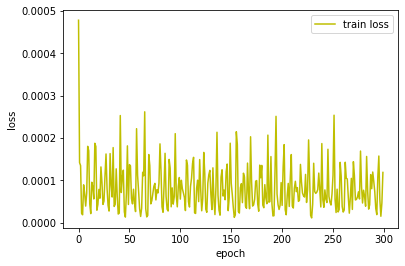

result :  0.002757726565879934


In [8]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')
plt.show()
print('result : ', results)

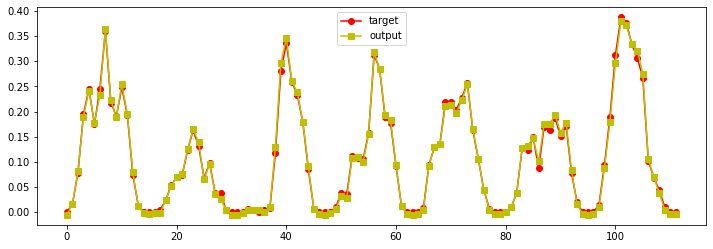

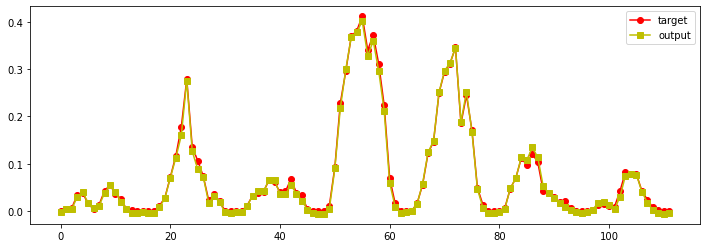

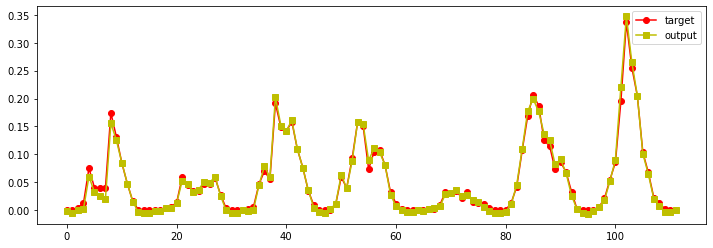

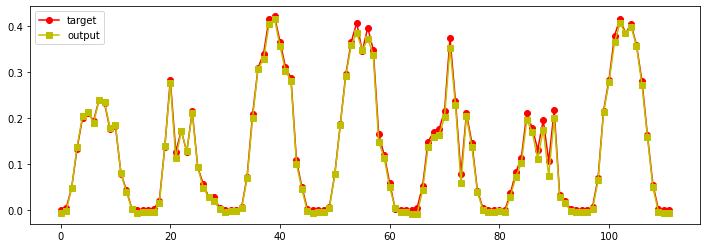

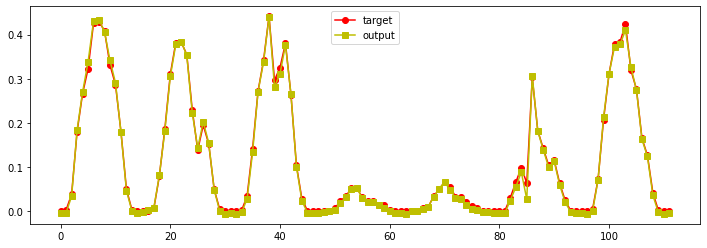

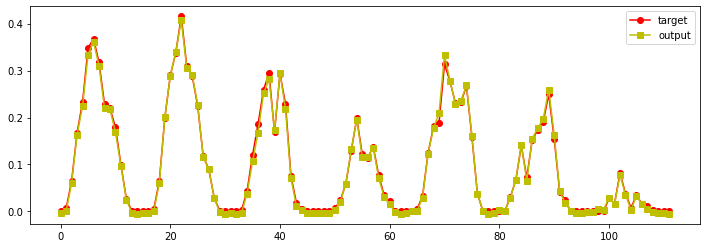

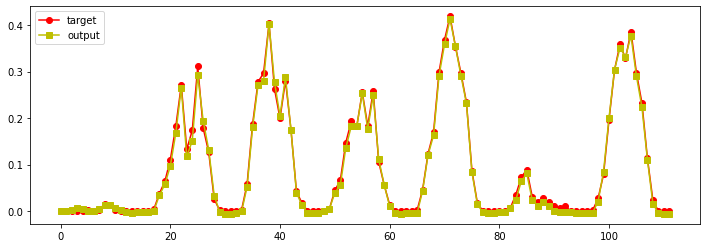

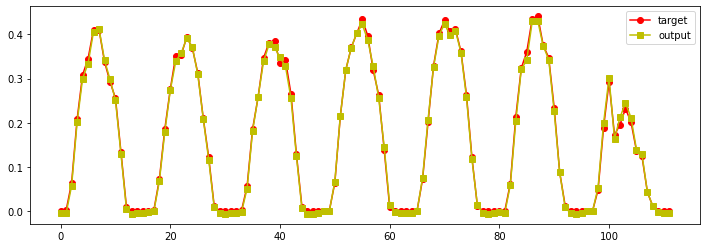

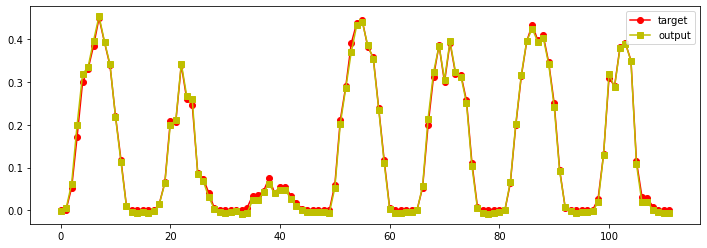

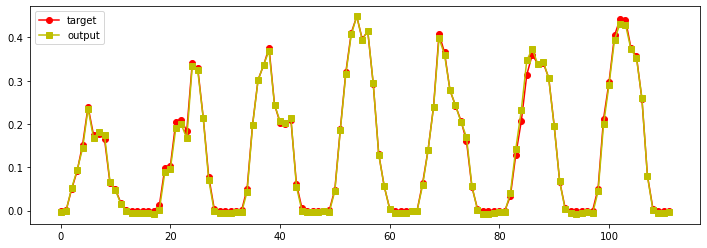

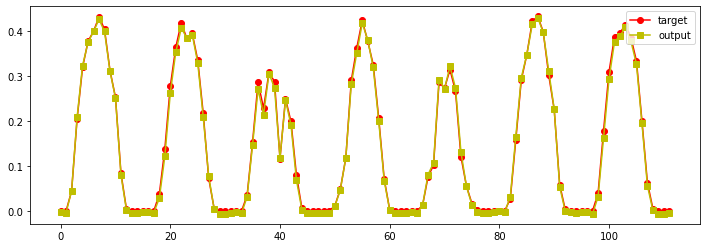

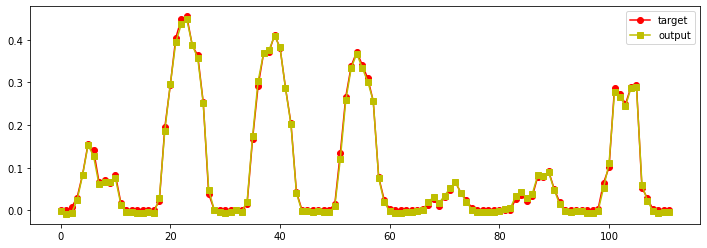

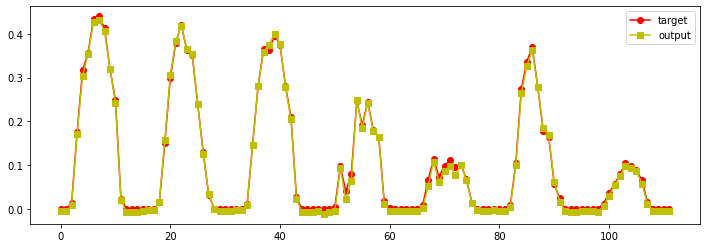

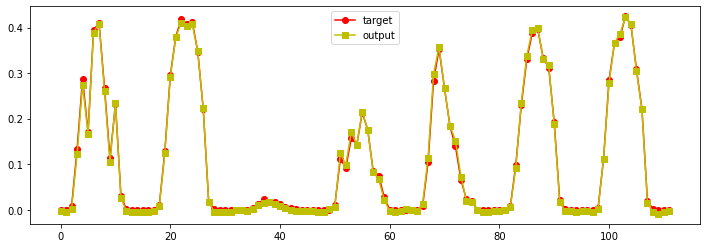

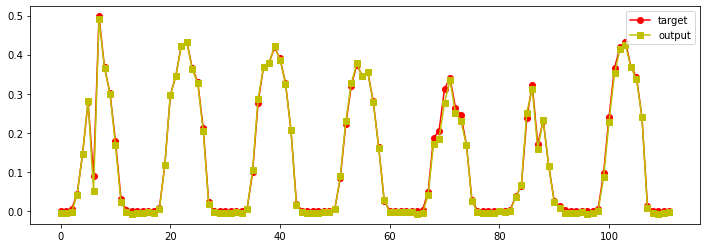

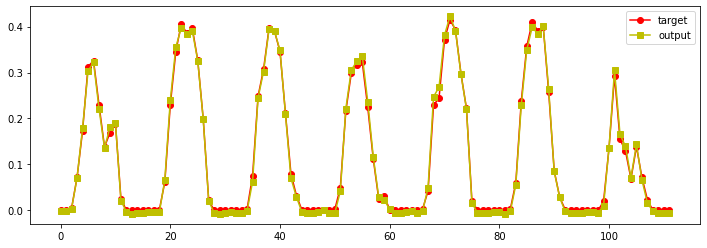

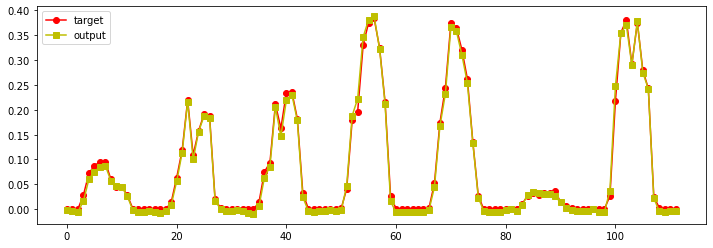

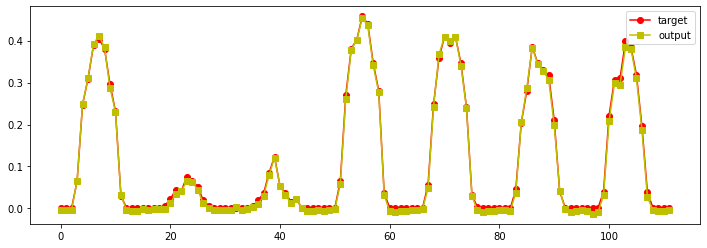

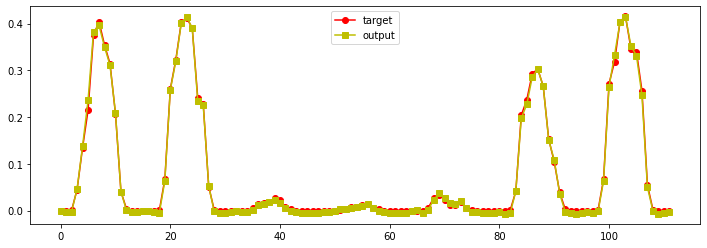

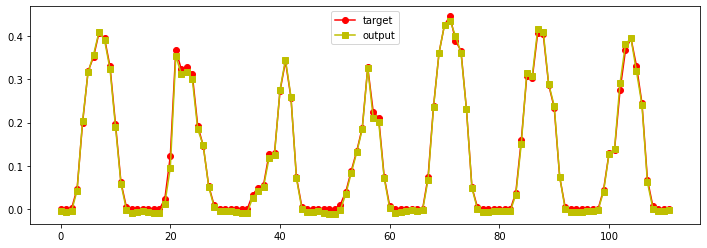

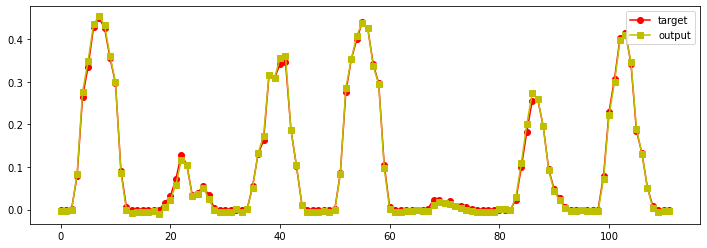

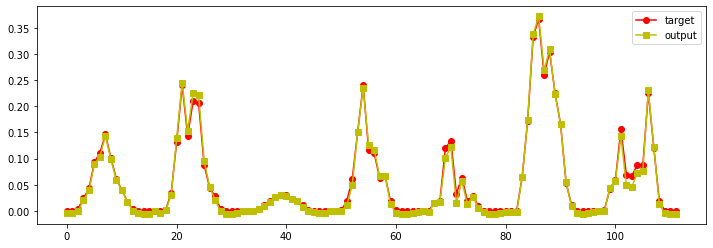

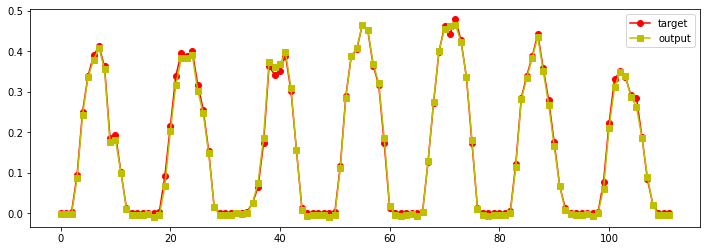

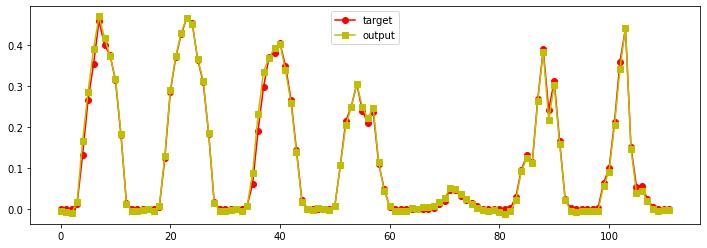

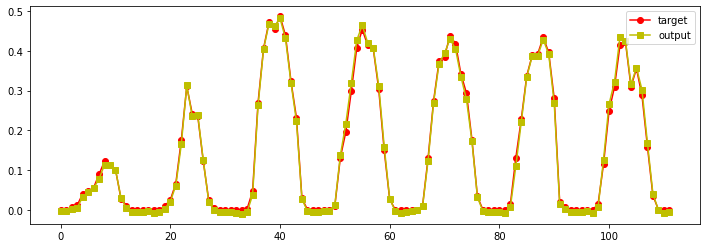

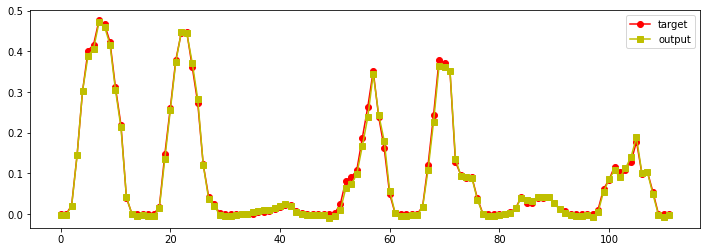

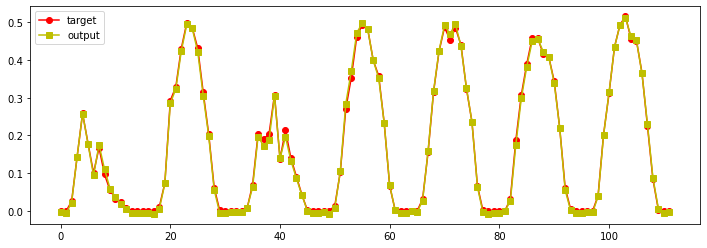

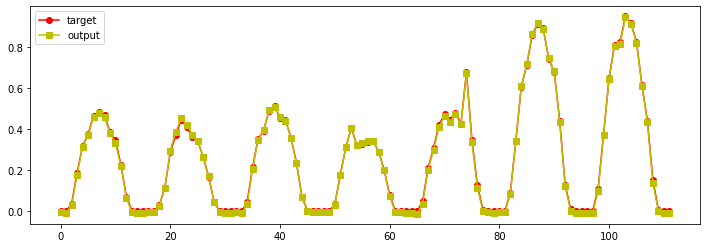

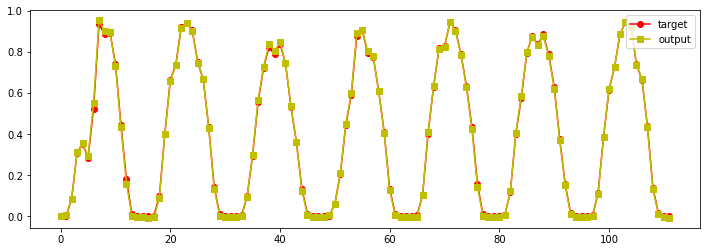

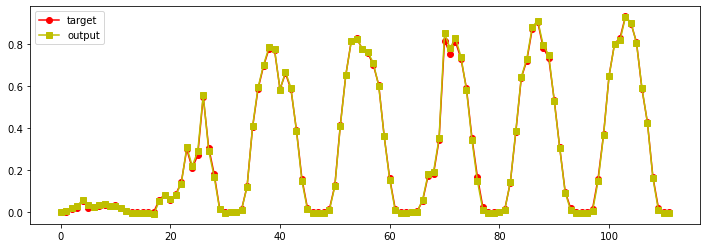

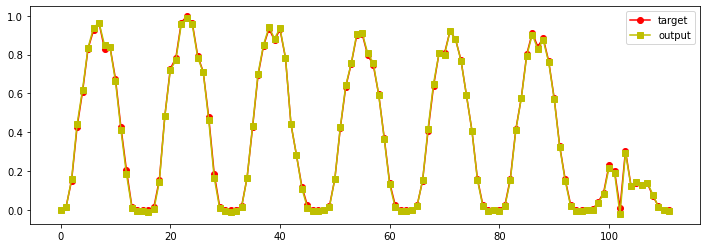

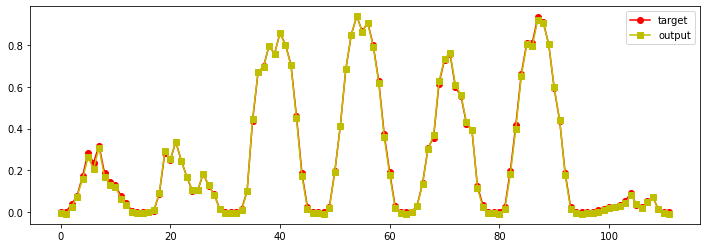

In [9]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)

end = 48
step = hoursteps*7
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+step], 'ro-', label="target")
    plt.plot(plotY_pred[i:i+step], 'ys-', label="output")
    plt.legend()
    plt.show()

#print(plotY_pred)

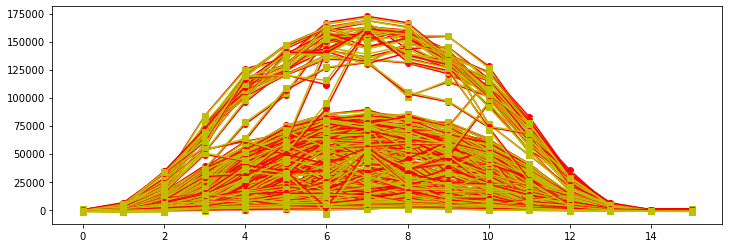

In [10]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
#pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'ro-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'ys-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 94.87224669603525


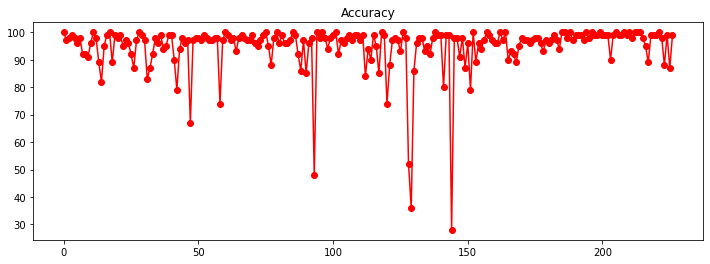

[100.0, 97.0, 98.0, 99.0, 98.0, 96.0, 98.0, 92.0, 92.0, 91.0, 96.0, 100.0, 98.0, 89.0, 82.0, 95.0, 99.0, 100.0, 89.0, 99.0, 98.0, 99.0, 95.0, 97.0, 96.0, 92.0, 87.0, 97.0, 100.0, 99.0, 97.0, 83.0, 87.0, 92.0, 98.0, 96.0, 99.0, 94.0, 95.0, 99.0, 99.0, 90.0, 79.0, 94.0, 98.0, 96.0, 97.0, 67.0, 97.0, 98.0, 98.0, 97.0, 99.0, 98.0, 97.0, 97.0, 98.0, 98.0, 74.0, 97.0, 100.0, 99.0, 97.0, 98.0, 93.0, 98.0, 99.0, 98.0, 97.0, 97.0, 99.0, 96.0, 95.0, 97.0, 99.0, 100.0, 95.0, 88.0, 98.0, 100.0, 96.0, 99.0, 96.0, 96.0, 97.0, 100.0, 99.0, 92.0, 86.0, 97.0, 85.0, 96.0, 98.0, 48.0, 100.0, 98.0, 100.0, 98.0, 94.0, 98.0, 99.0, 100.0, 92.0, 97.0, 96.0, 98.0, 99.0, 97.0, 99.0, 99.0, 97.0, 99.0, 84.0, 94.0, 90.0, 99.0, 95.0, 85.0, 100.0, 99.0, 74.0, 88.0, 97.0, 98.0, 97.0, 93.0, 100.0, 98.0, 52.0, 36.0, 86.0, 96.0, 98.0, 98.0, 93.0, 95.0, 92.0, 98.0, 100.0, 99.0, 99.0, 80.0, 99.0, 99.0, 28.0, 98.0, 98.0, 91.0, 98.0, 87.0, 96.0, 79.0, 100.0, 89.0, 96.0, 94.0, 97.0, 100.0, 99.0, 97.0, 96.0, 96.0, 100.0, 97.0

In [11]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.show()
print(acc_list)


# model들 acc 평균 출력

In [15]:

from keras.models import load_model

#get test data
X_test = np.load("npset/"+season_mod+"_testX.npy")
y_test = np.load("npset/"+season_mod+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
model       = []

for i in range(n_model):
    model.append(load_model('model/model_'+season_mod+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    #if(i in [0,5,13,14,24,25]): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = model[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        pred = np.sum(pred)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-pred), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    if(i%5==0): print(" ")
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (34, 48, 8)
y_test :  (34, 16, 1)


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[ dataset ]
 
18.5 / 64.6 / 64.8 / 66.0 / 61.2 /  
65.9 / 89.2 / 63.5 / 83.3 / 83.2 /  
36.0 / 61.3 / 67.8 / 44.5 / 57.9 /  
77.4 / 68.8 / 83.6 / 86.8 / 68.6 /  
43.2 / 82.9 / 61.5 / 77.3 / 21.4 /  
36.8 / 86.1 / 89.5 / 60.0 / 53.9 /  
42.3 / 77.4 / 63.1 / 30.3 / 
----------------------------------------------
mean(acc rate): 62.9
----------------------------------------------
[ model ]
47.68
78.62
67.65
61.71
48.5
62.24
65.53
64.03
65.97
67.09


In [18]:

from keras.models import load_model

#get test data
X_test = np.load("npset/"+season_mod+"_testX.npy")
y_test = np.load("npset/"+season_mod+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
model       = []
low_list    = [0,10,11,13,14,20,24,25,28,29,30,32,33]
for i in range(n_model):
    model.append(load_model('model/model_'+season_mod+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    if(i%5==0): print(" ")
    if(i in low_list): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = model[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        pred = np.sum(pred)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-pred), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
        
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset-len(low_list)),2)
    print(acc_model[i])

X_test :  (34, 48, 8)
y_test :  (34, 16, 1)


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[ dataset ]
 
64.6 / 64.8 / 66.0 / 61.2 /  
65.9 / 89.2 / 63.5 / 83.3 / 83.2 /  
67.8 /  
77.4 / 68.8 / 83.6 / 86.8 / 68.6 /  
82.9 / 61.5 / 77.3 /  
86.1 / 89.5 /  
77.4 / 
----------------------------------------------
mean(acc rate): 74.73333333333333
----------------------------------------------
[ model ]
51.0
86.38
74.38
73.95
59.57
75.67
80.9
80.38
81.81
83.29
